In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras
from keras.layers import Dropout
import tensorflow as tf
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




###**Preprocessing of the data**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      shear_range = 0.2, 
      zoom_range = 0.2, 
      height_shift_range = 0.2,
      width_shift_range = 0.2,
      horizontal_flip = True, 
      )

In [ ]:
# this is the augmentation configuration we will use for testing:
test_datagen = ImageDataGenerator(rescale=1. / 255)     # only rescaling

In [ ]:
# input image dimensions
img_rows, img_cols = 224, 224

train_data = train_datagen.flow_from_directory('/content/drive/MyDrive/Final Year Project/train', 
                                            target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

test_data = test_datagen.flow_from_directory('/content/drive/MyDrive/Final Year Project/test',
                                          target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 1600 images belonging to 4 classes.
Found 439 images belonging to 4 classes.


In [ ]:
Y = train_data.class_indices
Y

{'Acne and Rosacea': 0,
 'Melanoma Skin Cancer Nevi and Moles': 1,
 'Psoriasis pictures Lichen Planus and related diseases': 2,
 'Vasculitis': 3}

###**Pre-trained model - MobileNet Classifier**###

In [ ]:
model= tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
model_trainable = False

###**Model Training**###

In [ ]:
base_input = model.layers[0].input
base_output = model.layers[-5].output

# 4 corresponds to the number of classes
Flat_layer = layers.Flatten()(base_output)

dense = layers.Dense(1024, activation="relu")
x = dense(Flat_layer) 
dense1 = layers.Dense(512, activation="relu")
x1 = dense1(x)
dense2 = layers.Dense(256, activation="relu")
x2 = dense2(x1)
dense2 = layers.Dense(64, activation="relu")
x3 = dense2(x2)
final_output= layers.Dense(4)(x3)
dp = Dropout(0.2)
x = dp(final_output)
final_output= layers.Activation('softmax')(x)

In [ ]:
model = keras.Model(inputs = base_input, outputs= final_output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

###**Compiling and fitting the Model**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 1.0430 - accuracy: 0.5900 
Epoch 00001: val_loss improved from inf to 1.25438, saving model to mobilenet.h5
50/50 [==============================] - 1025s 21s/step - loss: 1.0430 - accuracy: 0.5900 - val_loss: 1.2544 - val_accuracy: 0.4738
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.6938
Epoch 00002: val_loss improved from 1.25438 to 1.06771, saving model to mobilenet.h5
50/50 [==============================] - 42s 841ms/step - loss: 0.7694 - accuracy: 0.6938 - val_loss: 1.0677 - val_accuracy: 0.6264
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.6693 - accuracy: 0.7375
Epoch 00003: val_loss improved from 1.06771 to 1.05736, saving model to mobilenet.h5
50/50 [==============================] - 43s 852ms/step - loss: 0.6693 - accuracy: 0.7375 - val_loss: 1.0574 - val_accuracy: 0.6674
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.

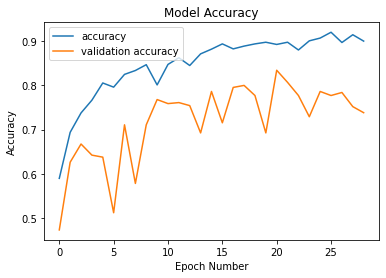

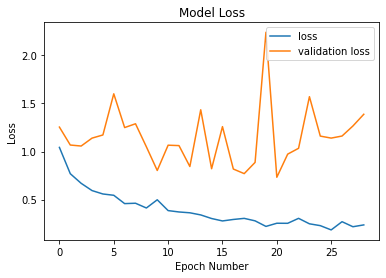

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# simple early stopping
#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(monitor='val_loss', patience=8, mode='min')
model_chkpt = ModelCheckpoint('mobilenet.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
h = model.fit_generator(train_data, epochs = 50, validation_data = test_data, callbacks=[model_chkpt, early_stopper], verbose=1)
model.save('final_mobilenet.h5')
# summarize history for accuracy
plt.plot(h.history['accuracy'],label='accuracy')
plt.plot(h.history['val_accuracy'],label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h.history['loss'],label='loss')
plt.plot(h.history['val_loss'],label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.save('final_mobnet.h5')

###**Predictions on test data**

In [1]:
from keras.models import load_model
import cv2

In [4]:
model = load_model('/content/drive/MyDrive/Final Year Project/final_mobilenet.h5', compile=True)

In [6]:
#saving model in JSON format
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)
model.save_weights("final_mobilenet1.h5")

In [7]:
from tensorflow.keras.models import model_from_json
j_file = open('model.json', 'r')
loaded_json_model = j_file.read()
j_file.close()
model = model_from_json(loaded_json_model)
model.load_weights('final_mobilenet1.h5')

In [8]:
img = '/content/drive/MyDrive/Final Year Project/test/Acne and Rosacea /acne-excoriated-22.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
#print(prediction)
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)

{'Acne and Rosacea': 0.9375059, 'Melanoma Skin Cancer Nevi and Moles': 0.00846882, 'Psoriasis pictures Lichen Planus and related diseases': 0.0321764, 'Vasculitis': 0.021848831}


In [ ]:
img = '/content/drive/MyDrive/Final Year Project/test/Vasculitis/schamberg-disease-19.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][3])

{'Acne and Rosacea': 0.0006391513, 'Melanoma Skin Cancer Nevi and Moles': 0.0020053394, 'Psoriasis pictures Lichen Planus and related diseases': 0.21867402, 'Vasculitis': 0.7786814}


In [ ]:
img = '/content/drive/MyDrive/Final Year Project/test/Psoriasis pictures Lichen Planus and related diseases/psoriasis-pustular-generalized-5.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][2])

{'Acne and Rosacea': 0.00059720414, 'Melanoma Skin Cancer Nevi and Moles': 0.01189053, 'Psoriasis pictures Lichen Planus and related diseases': 0.9659284, 'Vasculitis': 0.02158387}


In [ ]:
img = '/content/drive/MyDrive/Final Year Project/test/Acne and Rosacea /acne-excoriated-22.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][0])

{'Acne and Rosacea': 0.9375059, 'Melanoma Skin Cancer Nevi and Moles': 0.00846882, 'Psoriasis pictures Lichen Planus and related diseases': 0.0321764, 'Vasculitis': 0.021848831}


In [ ]:
img = '/content/drive/MyDrive/Final Year Project/test/Mela Test/atypical-nevi-23.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][0])

{'Acne and Rosacea': 1.0731877e-05, 'Melanoma Skin Cancer Nevi and Moles': 0.9999572, 'Psoriasis pictures Lichen Planus and related diseases': 3.910479e-06, 'Vasculitis': 2.8165785e-05}


In [ ]:
img = '/content/drive/MyDrive/Final Year Project/test/Acne and Rosacea /acne-excoriated-22.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction)

{'Acne and Rosacea': 0.9375059, 'Melanoma Skin Cancer Nevi and Moles': 0.00846882, 'Psoriasis pictures Lichen Planus and related diseases': 0.0321764, 'Vasculitis': 0.021848831}


###**Predictions on unknown images**

{'Acne and Rosacea': 56.92703723907471, 'Melanoma Skin Cancer Nevi and Moles': 30.75692057609558, 'Psoriasis pictures Lichen Planus and related diseases': 5.979138985276222, 'Vasculitis': 6.3369013369083405}


'\n\nplt.bar(*zip(*d.items()))\nplt.figure(figsize=(20,20))\nplt.show()\n'

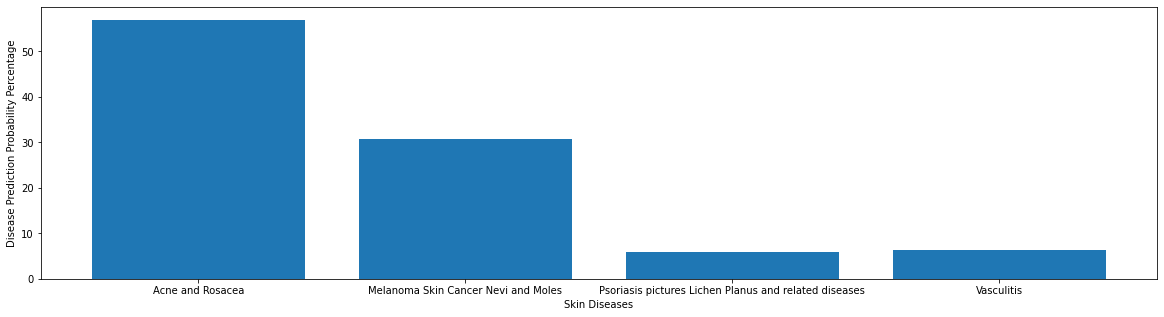

In [ ]:
img = '/content/drive/MyDrive/Final Year Project/a.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = (prediction[0][0]*100)
d['Melanoma Skin Cancer Nevi and Moles'] =(prediction[0][1]*100)
d['Psoriasis pictures Lichen Planus and related diseases'] = (prediction[0][2]*100)
d['Vasculitis'] = (prediction[0][3]*100)
print(d)
#print(prediction[0][3])

import matplotlib.pyplot as plt

keys = d.keys()
values = d.values()
plt.figure(figsize=(20,5))
plt.xlabel("Skin Diseases")
plt.ylabel("Disease Prediction Probability Percentage")
plt.bar(keys, values)
"""

plt.bar(*zip(*d.items()))
plt.figure(figsize=(20,20))
plt.show()
"""

In [ ]:
img = '/content/drive/MyDrive/Final Year Project/vas.jfif'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][3])

{'Acne and Rosacea': 0.00045108073, 'Melanoma Skin Cancer Nevi and Moles': 0.00373276, 'Psoriasis pictures Lichen Planus and related diseases': 0.00046464163, 'Vasculitis': 0.99535143}


In [ ]:
img = '/content/drive/MyDrive/Final Year Project/pso.jfif'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][2])

{'Acne and Rosacea': 0.0027407673, 'Melanoma Skin Cancer Nevi and Moles': 0.0075728833, 'Psoriasis pictures Lichen Planus and related diseases': 0.5011549, 'Vasculitis': 0.4885314}


In [ ]:
img = '/content/drive/MyDrive/Final Year Project/mel.jfif'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][1])

{'Acne and Rosacea': 0.0007780342, 'Melanoma Skin Cancer Nevi and Moles': 0.9847189, 'Psoriasis pictures Lichen Planus and related diseases': 0.0019842123, 'Vasculitis': 0.0125188185}


In [1]:
import tensorflow as tf; print(tf.__version__)


2.7.0
